In [1]:
# [CLS]トークンを利用
# anchorとtargetをそれぞれ特徴量抽出

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [40]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='006'
    wandb=True
    resume=None  # [None, 'auto', 'always']
    save_checkpoint=True
    competition='PPPM'
    debug=False  # False
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=12
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=4
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = False  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = '"re create"'  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Fri Jun  3 11:57:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
CPU times: user 53 ms, sys: 28.3 ms, total: 81.3 ms
Wall time: 2.37 s


In [41]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb and (not CFG.debug):
    
    !pip install -q wandb
    import wandb

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        with open('/content/drive/MyDrive/kaggle/wandb') as f:
           wandb_api_key = f.readline().rstrip('\n')
        wandb.login(key=wandb_api_key)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                     name=CFG.exp,
                     config=class2dict(CFG),
                    #  group=CFG.exp,
                     job_type="train",
                     resume=CFG.resume,  # 'auto'
                     anonymous=anony)

wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [10]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [11]:
# contextの';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

train['anchor'] = train['anchor'] + '.'
test['anchor'] = test['anchor'] + '.'

train['target'] = train['target'] + '.'
test['target'] = test['target'] + '.'

display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement.,abatement of pollution.,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement.,act of abating.,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement.,active catalyst.,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement.,eliminating process.,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement.,forest region.,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum.,inorganic photoconductor drum.,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow.,altering gas flow.,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...
2,36baf228038e314b,lower trunnion.,lower locating.,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component.,upper portion.,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation.,artificial neural network.,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


# EDA

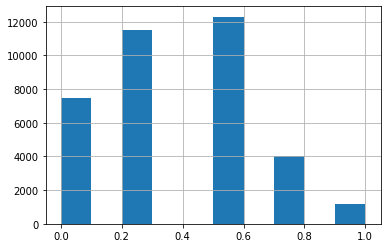

In [12]:
train['score'].hist()

In [13]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [14]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [15]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [16]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [17]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(
                max(lengths_dict['anchor']) + max(lengths_dict['context_text']),
                max(lengths_dict['target']) + max(lengths_dict['context_text'])
              ) + 3 # CLS + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 100


In [18]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text, context):
    inputs = cfg.tokenizer(text, context,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.anchors = df['anchor'].values
        self.targets = df['target'].values
        self.contexts = df['context_text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        anchor_inputs = prepare_input(self.cfg, self.anchors[item], self.contexts[item])
        target_inputs = prepare_input(self.cfg, self.targets[item], self.contexts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return anchor_inputs, target_inputs, label

In [19]:
train_dataset = TrainDataset(CFG, train, 'train')
anchor_inputs, target_inputs, label = train_dataset[0]
print(anchor_inputs)
print(target_inputs)
print(label)

{'input_ids': tensor([    1, 47284,   260,     2,   857, 19629,   260,  2075,   260,  3090,
         2502,   289,  6328,   260,  1818, 13498,   260, 10224, 13498,   260,
        22157, 13952,   267,  1042,     2,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 

# Model

In [20]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size * 2, self.cfg.target_size)  # anchorとtargetののhidden_statesををconcatするから2倍
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]  # (bs, max_len, hidden_size)
        feature = last_hidden_states[:, 0, :]  # [CLS]トークンを利用
        # feature = torch.mean(last_hidden_states, dim=1)  # 全トークンを平均
        # weights = self.attention(last_hidden_states)
        # feature = torch.sum(weights * last_hidden_states, dim=1)  # 全トークンを全トークンをattentionレイヤで加重平均
        return feature

    def forward(self, anchor_inputs, target_inputs):
        anchor_feature = self.feature(anchor_inputs)
        target_feature = self.feature(target_inputs)
        feature = torch.cat([anchor_feature, target_feature], dim=1)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [21]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (anchor_inputs, target_inputs, labels) in enumerate(train_loader):
        for inputs in [anchor_inputs, target_inputs]:
            for k, v in inputs.items():
                inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(anchor_inputs, target_inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (anchor_inputs, target_inputs, labels) in enumerate(valid_loader):
        for inputs in [anchor_inputs, target_inputs]:
            for k, v in inputs.items():
                inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(anchor_inputs, target_inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for anchor_inputs, target_inputs in tk0:
        for inputs in [anchor_inputs, target_inputs]:
            for k, v in inputs.items():
                inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(anchor_inputs, target_inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [22]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [23]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/2257] Elapsed 0m 1s (remain 59m 19s) Loss: 0.7687(0.7687) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2257] Elapsed 1m 54s (remain 40m 54s) Loss: 0.7135(0.6870) Grad: 175176.7188  LR: 0.00001999  
Epoch: [1][200/2257] Elapsed 3m 47s (remain 38m 42s) Loss: 0.7177(0.6857) Grad: 128521.9531  LR: 0.00001998  
Epoch: [1][300/2257] Elapsed 5m 39s (remain 36m 47s) Loss: 0.6623(0.6817) Grad: 296101.0000  LR: 0.00001995  
Epoch: [1][400/2257] Elapsed 7m 31s (remain 34m 51s) Loss: 0.6725(0.6784) Grad: 90196.0156  LR: 0.00001990  
Epoch: [1][500/2257] Elapsed 9m 24s (remain 32m 57s) Loss: 0.7381(0.6723) Grad: 153388.6875  LR: 0.00001985  
Epoch: [1][600/2257] Elapsed 11m 16s (remain 31m 3s) Loss: 0.5185(0.6678) Grad: 55715.3398  LR: 0.00001978  
Epoch: [1][700/2257] Elapsed 13m 8s (remain 29m 10s) Loss: 0.5136(0.6641) Grad: 161739.0312  LR: 0.00001970  
Epoch: [1][800/2257] Elapsed 15m 0s (remain 27m 17s) Loss: 0.6170(0.6605) Grad: 161944.5938  LR: 0.00001961  
Epoch: [1][900/2257] El

Epoch 1 - avg_train_loss: 0.6361  avg_val_loss: 0.6219  time: 2793s
Epoch 1 - Score: 0.4975
Epoch 1 - Save Best Score: 0.4975 Model


Epoch: [2][0/2257] Elapsed 0m 1s (remain 62m 50s) Loss: 0.6048(0.6048) Grad: 88384.7500  LR: 0.00001707  
Epoch: [2][100/2257] Elapsed 2m 1s (remain 43m 19s) Loss: 0.5600(0.5766) Grad: 140502.9531  LR: 0.00001682  
Epoch: [2][200/2257] Elapsed 3m 54s (remain 39m 58s) Loss: 0.6875(0.5839) Grad: 367351.9375  LR: 0.00001656  
Epoch: [2][300/2257] Elapsed 5m 46s (remain 37m 33s) Loss: 0.5111(0.5870) Grad: 128690.4688  LR: 0.00001630  
Epoch: [2][400/2257] Elapsed 7m 39s (remain 35m 27s) Loss: 0.6336(0.5854) Grad: 66461.8984  LR: 0.00001602  
Epoch: [2][500/2257] Elapsed 9m 31s (remain 33m 24s) Loss: 0.5121(0.5824) Grad: 129383.0938  LR: 0.00001574  
Epoch: [2][600/2257] Elapsed 11m 24s (remain 31m 25s) Loss: 0.5991(0.5822) Grad: 218877.2812  LR: 0.00001545  
Epoch: [2][700/2257] Elapsed 13m 16s (remain 29m 27s) Loss: 0.5811(0.5838) Grad: 169138.9062  LR: 0.00001516  
Epoch: [2][800/2257] Elapsed 15m 9s (remain 27m 32s) Loss: 0.6959(0.5825) Grad: 116849.9922  LR: 0.00001486  
Epoch: [2][900

Epoch 2 - avg_train_loss: 0.5789  avg_val_loss: 0.6360  time: 2802s
Epoch 2 - Score: 0.5024


EVAL: [781/782] Elapsed 4m 17s (remain 0m 0s) Loss: 0.7993(0.6360) 


Epoch 2 - Save Best Score: 0.5024 Model


Epoch: [3][0/2257] Elapsed 0m 2s (remain 77m 58s) Loss: 0.4797(0.4797) Grad: 118436.5156  LR: 0.00001000  
Epoch: [3][100/2257] Elapsed 2m 0s (remain 42m 54s) Loss: 0.5274(0.5448) Grad: 96844.1641  LR: 0.00000965  
Epoch: [3][200/2257] Elapsed 3m 55s (remain 40m 6s) Loss: 0.5021(0.5460) Grad: 78507.7891  LR: 0.00000931  
Epoch: [3][300/2257] Elapsed 5m 47s (remain 37m 39s) Loss: 0.6378(0.5482) Grad: 148213.4219  LR: 0.00000896  
Epoch: [3][400/2257] Elapsed 7m 40s (remain 35m 31s) Loss: 0.6230(0.5495) Grad: 198794.0625  LR: 0.00000861  
Epoch: [3][500/2257] Elapsed 9m 32s (remain 33m 27s) Loss: 0.6447(0.5500) Grad: 83751.5859  LR: 0.00000827  
Epoch: [3][600/2257] Elapsed 11m 25s (remain 31m 28s) Loss: 0.5705(0.5502) Grad: 162641.6875  LR: 0.00000793  
Epoch: [3][700/2257] Elapsed 13m 17s (remain 29m 30s) Loss: 0.5654(0.5497) Grad: 84287.8672  LR: 0.00000759  
Epoch: [3][800/2257] Elapsed 15m 10s (remain 27m 34s) Loss: 0.2840(0.5485) Grad: 65825.4922  LR: 0.00000725  
Epoch: [3][900/22

Epoch 3 - avg_train_loss: 0.5457  avg_val_loss: 0.6542  time: 2802s
Epoch 3 - Score: 0.4811


EVAL: [781/782] Elapsed 4m 17s (remain 0m 0s) Loss: 0.7950(0.6542) 
Epoch: [4][0/2257] Elapsed 0m 1s (remain 58m 44s) Loss: 0.5610(0.5610) Grad: 256252.9219  LR: 0.00000293  
Epoch: [4][100/2257] Elapsed 1m 59s (remain 42m 36s) Loss: 0.4640(0.5216) Grad: 155568.0156  LR: 0.00000269  
Epoch: [4][200/2257] Elapsed 3m 52s (remain 39m 36s) Loss: 0.4379(0.5247) Grad: 107843.4375  LR: 0.00000246  
Epoch: [4][300/2257] Elapsed 5m 44s (remain 37m 19s) Loss: 0.5642(0.5305) Grad: 83647.0703  LR: 0.00000223  
Epoch: [4][400/2257] Elapsed 7m 37s (remain 35m 16s) Loss: 0.4476(0.5271) Grad: 88787.0469  LR: 0.00000202  
Epoch: [4][500/2257] Elapsed 9m 29s (remain 33m 17s) Loss: 0.6207(0.5258) Grad: 70560.1406  LR: 0.00000181  
Epoch: [4][600/2257] Elapsed 11m 22s (remain 31m 21s) Loss: 0.5872(0.5256) Grad: 85433.5938  LR: 0.00000162  
Epoch: [4][700/2257] Elapsed 13m 15s (remain 29m 25s) Loss: 0.4523(0.5255) Grad: 59562.3594  LR: 0.00000143  
Epoch: [4][800/2257] Elapsed 15m 7s (remain 27m 29s) Loss:

Epoch 4 - avg_train_loss: 0.5259  avg_val_loss: 0.6864  time: 2806s
Epoch 4 - Score: 0.4687


EVAL: [781/782] Elapsed 4m 18s (remain 0m 0s) Loss: 0.8604(0.6864) 


========== fold: 0 result ==========
Score: 0.5024
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2301] Elapsed 0m 1s (remain 72m 20s) Loss: 0.8330(0.8330) Grad: nan  LR: 0.00002000  
Epoch: [1][100/2301] Elapsed 1m 59s (remain 43m 24s) Loss: 0.7253(0.7005) Grad: 53735.2461  LR: 0.00001999  
Epoch: [1][200/2301] Elapsed 3m 52s (remain 40m 27s) Loss: 0.6156(0.6932) Grad: 67890.0859  LR: 0.00001998  
Epoch: [1][300/2301] Elapsed 5m 44s (remain 38m 11s) Loss: 0.6044(0.6847) Grad: 25268.4473  LR: 0.00001995  
Epoch: [1][400/2301] Elapsed 7m 37s (remain 36m 6s) Loss: 0.6455(0.6737) Grad: 69572.2422  LR: 0.00001991  
Epoch: [1][500/2301] Elapsed 9m 29s (remain 34m 6s) Loss: 0.7048(0.6705) Grad: 54138.9844  LR: 0.00001985  
Epoch: [1][600/2301] Elapsed 11m 22s (remain 32m 10s) Loss: 0.6109(0.6682) Grad: 85071.4688  LR: 0.00001979  
Epoch: [1][700/2301] Elapsed 13m 15s (remain 30m 15s) Loss: 0.6630(0.6668) Grad: 43677.8047  LR: 0.00001972  
Epoch: [1][800/2301] Elapsed 15m 7s (remain 28m 20s) Loss: 0.6898(0.6632) Grad: 85801.6875  LR: 0.00001963  
Epoch: [1][900/2301] Elapsed 

Epoch 1 - avg_train_loss: 0.6368  avg_val_loss: 0.6171  time: 2843s
Epoch 1 - Score: 0.5127


EVAL: [738/739] Elapsed 4m 4s (remain 0m 0s) Loss: 0.7072(0.6171) 


Epoch 1 - Save Best Score: 0.5127 Model


Epoch: [2][0/2301] Elapsed 0m 1s (remain 68m 24s) Loss: 0.6262(0.6262) Grad: 147468.3125  LR: 0.00001707  
Epoch: [2][100/2301] Elapsed 2m 3s (remain 44m 44s) Loss: 0.6329(0.5777) Grad: 52407.2188  LR: 0.00001682  
Epoch: [2][200/2301] Elapsed 3m 56s (remain 41m 6s) Loss: 0.6012(0.5928) Grad: 145012.1406  LR: 0.00001657  
Epoch: [2][300/2301] Elapsed 5m 48s (remain 38m 35s) Loss: 0.5762(0.5921) Grad: 167620.4062  LR: 0.00001631  
Epoch: [2][400/2301] Elapsed 7m 41s (remain 36m 24s) Loss: 0.5489(0.5943) Grad: 67926.9922  LR: 0.00001604  
Epoch: [2][500/2301] Elapsed 9m 33s (remain 34m 22s) Loss: 0.5657(0.5916) Grad: 78800.2422  LR: 0.00001576  
Epoch: [2][600/2301] Elapsed 11m 26s (remain 32m 21s) Loss: 0.4876(0.5887) Grad: 60181.0469  LR: 0.00001548  
Epoch: [2][700/2301] Elapsed 13m 19s (remain 30m 23s) Loss: 0.4185(0.5856) Grad: 66216.6172  LR: 0.00001519  
Epoch: [2][800/2301] Elapsed 15m 11s (remain 28m 27s) Loss: 0.6349(0.5870) Grad: 69564.9062  LR: 0.00001490  
Epoch: [2][900/230

Epoch 2 - avg_train_loss: 0.5816  avg_val_loss: 0.6205  time: 2845s
Epoch 2 - Score: 0.5285


EVAL: [738/739] Elapsed 4m 4s (remain 0m 0s) Loss: 0.7075(0.6205) 


Epoch 2 - Save Best Score: 0.5285 Model


Epoch: [3][0/2301] Elapsed 0m 1s (remain 68m 18s) Loss: 0.6010(0.6010) Grad: 162001.2500  LR: 0.00001000  
Epoch: [3][100/2301] Elapsed 1m 59s (remain 43m 19s) Loss: 0.4759(0.5706) Grad: 86786.9297  LR: 0.00000966  
Epoch: [3][200/2301] Elapsed 3m 54s (remain 40m 46s) Loss: 0.6116(0.5650) Grad: 106167.6641  LR: 0.00000931  
Epoch: [3][300/2301] Elapsed 5m 46s (remain 38m 23s) Loss: 0.6036(0.5589) Grad: 96431.8672  LR: 0.00000897  
Epoch: [3][400/2301] Elapsed 7m 39s (remain 36m 15s) Loss: 0.5743(0.5595) Grad: 63395.7578  LR: 0.00000864  
Epoch: [3][500/2301] Elapsed 9m 31s (remain 34m 14s) Loss: 0.6698(0.5567) Grad: 117852.1406  LR: 0.00000830  
Epoch: [3][600/2301] Elapsed 11m 24s (remain 32m 15s) Loss: 0.3995(0.5572) Grad: 42155.5625  LR: 0.00000796  
Epoch: [3][700/2301] Elapsed 13m 16s (remain 30m 18s) Loss: 0.4020(0.5557) Grad: 79935.8047  LR: 0.00000763  
Epoch: [3][800/2301] Elapsed 15m 9s (remain 28m 22s) Loss: 0.4448(0.5553) Grad: 69121.1484  LR: 0.00000730  
Epoch: [3][900/23

Epoch 3 - avg_train_loss: 0.5501  avg_val_loss: 0.6459  time: 2842s
Epoch 3 - Score: 0.4952


EVAL: [738/739] Elapsed 4m 4s (remain 0m 0s) Loss: 0.6806(0.6459) 
Epoch: [4][0/2301] Elapsed 0m 1s (remain 62m 39s) Loss: 0.4960(0.4960) Grad: 214952.8594  LR: 0.00000293  
Epoch: [4][100/2301] Elapsed 2m 1s (remain 44m 1s) Loss: 0.4068(0.5341) Grad: 32414.6934  LR: 0.00000269  
Epoch: [4][200/2301] Elapsed 3m 53s (remain 40m 40s) Loss: 0.5862(0.5362) Grad: 136876.5938  LR: 0.00000246  
Epoch: [4][300/2301] Elapsed 5m 46s (remain 38m 20s) Loss: 0.5350(0.5375) Grad: 52600.8320  LR: 0.00000224  
Epoch: [4][400/2301] Elapsed 7m 38s (remain 36m 11s) Loss: 0.5694(0.5383) Grad: 62635.9062  LR: 0.00000203  
Epoch: [4][500/2301] Elapsed 9m 30s (remain 34m 10s) Loss: 0.3602(0.5369) Grad: 54097.8711  LR: 0.00000183  
Epoch: [4][600/2301] Elapsed 11m 23s (remain 32m 12s) Loss: 0.4456(0.5360) Grad: 51918.2734  LR: 0.00000164  
Epoch: [4][700/2301] Elapsed 13m 15s (remain 30m 16s) Loss: 0.4837(0.5364) Grad: 39628.0781  LR: 0.00000145  
Epoch: [4][800/2301] Elapsed 15m 7s (remain 28m 20s) Loss: 0.4

Epoch 4 - avg_train_loss: 0.5328  avg_val_loss: 0.6572  time: 2839s
Epoch 4 - Score: 0.4951


EVAL: [738/739] Elapsed 4m 3s (remain 0m 0s) Loss: 0.6764(0.6572) 


========== fold: 1 result ==========
Score: 0.5285
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2321] Elapsed 0m 1s (remain 70m 54s) Loss: 0.7802(0.7802) Grad: inf  LR: 0.00002000  
Epoch: [1][100/2321] Elapsed 1m 59s (remain 43m 57s) Loss: 0.7872(0.6853) Grad: 254727.7656  LR: 0.00001999  
Epoch: [1][200/2321] Elapsed 3m 52s (remain 40m 52s) Loss: 0.6591(0.6836) Grad: 74351.6406  LR: 0.00001998  
Epoch: [1][300/2321] Elapsed 5m 44s (remain 38m 34s) Loss: 0.7479(0.6790) Grad: 76901.6250  LR: 0.00001995  
Epoch: [1][400/2321] Elapsed 7m 37s (remain 36m 30s) Loss: 0.6660(0.6740) Grad: 29483.9238  LR: 0.00001991  
Epoch: [1][500/2321] Elapsed 9m 29s (remain 34m 30s) Loss: 0.6497(0.6697) Grad: 50308.0898  LR: 0.00001986  
Epoch: [1][600/2321] Elapsed 11m 22s (remain 32m 33s) Loss: 0.8011(0.6665) Grad: 96645.9766  LR: 0.00001979  
Epoch: [1][700/2321] Elapsed 13m 15s (remain 30m 37s) Loss: 0.5520(0.6627) Grad: 74761.0000  LR: 0.00001972  
Epoch: [1][800/2321] Elapsed 15m 7s (remain 28m 42s) Loss: 0.5792(0.6600) Grad: 46837.2930  LR: 0.00001964  
Epoch: [1][900/2321] Elaps

Epoch 1 - avg_train_loss: 0.6336  avg_val_loss: 0.6321  time: 2855s
Epoch 1 - Score: 0.4880


EVAL: [717/718] Elapsed 3m 56s (remain 0m 0s) Loss: 0.7608(0.6321) 


Epoch 1 - Save Best Score: 0.4880 Model


Epoch: [2][0/2321] Elapsed 0m 1s (remain 64m 18s) Loss: 0.5708(0.5708) Grad: 111946.9922  LR: 0.00001707  
Epoch: [2][100/2321] Elapsed 2m 5s (remain 45m 51s) Loss: 0.6087(0.5819) Grad: 81949.0234  LR: 0.00001683  
Epoch: [2][200/2321] Elapsed 3m 57s (remain 41m 49s) Loss: 0.6457(0.5822) Grad: 51629.9766  LR: 0.00001658  
Epoch: [2][300/2321] Elapsed 5m 50s (remain 39m 11s) Loss: 0.5104(0.5826) Grad: 105881.2891  LR: 0.00001632  
Epoch: [2][400/2321] Elapsed 7m 42s (remain 36m 55s) Loss: 0.4189(0.5843) Grad: 77268.5469  LR: 0.00001605  
Epoch: [2][500/2321] Elapsed 9m 35s (remain 34m 50s) Loss: 0.5696(0.5858) Grad: 61194.4492  LR: 0.00001578  
Epoch: [2][600/2321] Elapsed 11m 27s (remain 32m 48s) Loss: 0.5895(0.5837) Grad: 74064.7031  LR: 0.00001550  
Epoch: [2][700/2321] Elapsed 13m 20s (remain 30m 49s) Loss: 0.6193(0.5826) Grad: 102021.7422  LR: 0.00001521  
Epoch: [2][800/2321] Elapsed 15m 12s (remain 28m 52s) Loss: 0.5192(0.5811) Grad: 50014.6250  LR: 0.00001492  
Epoch: [2][900/23

Epoch 2 - avg_train_loss: 0.5766  avg_val_loss: 0.6503  time: 2859s
Epoch 2 - Score: 0.4801


EVAL: [717/718] Elapsed 3m 56s (remain 0m 0s) Loss: 0.7112(0.6503) 
Epoch: [3][0/2321] Elapsed 0m 1s (remain 63m 12s) Loss: 0.5399(0.5399) Grad: 140652.8906  LR: 0.00001000  
Epoch: [3][100/2321] Elapsed 2m 0s (remain 44m 4s) Loss: 0.4391(0.5479) Grad: 130728.1250  LR: 0.00000966  
Epoch: [3][200/2321] Elapsed 3m 52s (remain 40m 54s) Loss: 0.6803(0.5484) Grad: 228734.1250  LR: 0.00000933  
Epoch: [3][300/2321] Elapsed 5m 45s (remain 38m 36s) Loss: 0.3596(0.5497) Grad: 84996.8047  LR: 0.00000899  
Epoch: [3][400/2321] Elapsed 7m 37s (remain 36m 31s) Loss: 0.5907(0.5505) Grad: 92325.8828  LR: 0.00000865  
Epoch: [3][500/2321] Elapsed 9m 30s (remain 34m 32s) Loss: 0.6069(0.5485) Grad: 136985.8594  LR: 0.00000832  
Epoch: [3][600/2321] Elapsed 11m 23s (remain 32m 34s) Loss: 0.6623(0.5478) Grad: 56721.5469  LR: 0.00000799  
Epoch: [3][700/2321] Elapsed 13m 15s (remain 30m 38s) Loss: 0.5014(0.5486) Grad: 92598.1406  LR: 0.00000766  
Epoch: [3][800/2321] Elapsed 15m 8s (remain 28m 43s) Loss: 

Epoch 3 - avg_train_loss: 0.5472  avg_val_loss: 0.6610  time: 2854s
Epoch 3 - Score: 0.4800


EVAL: [717/718] Elapsed 3m 56s (remain 0m 0s) Loss: 0.6940(0.6610) 
Epoch: [4][0/2321] Elapsed 0m 1s (remain 62m 33s) Loss: 0.6135(0.6135) Grad: 149492.3281  LR: 0.00000293  
Epoch: [4][100/2321] Elapsed 2m 0s (remain 44m 10s) Loss: 0.5077(0.5307) Grad: 118231.2969  LR: 0.00000270  
Epoch: [4][200/2321] Elapsed 3m 52s (remain 40m 56s) Loss: 0.6493(0.5353) Grad: 164053.9531  LR: 0.00000247  
Epoch: [4][300/2321] Elapsed 5m 45s (remain 38m 38s) Loss: 0.5027(0.5340) Grad: 165250.2656  LR: 0.00000225  
Epoch: [4][400/2321] Elapsed 7m 37s (remain 36m 32s) Loss: 0.3996(0.5316) Grad: 160047.6406  LR: 0.00000204  
Epoch: [4][500/2321] Elapsed 9m 30s (remain 34m 32s) Loss: 0.4808(0.5298) Grad: 84401.5625  LR: 0.00000184  
Epoch: [4][600/2321] Elapsed 11m 22s (remain 32m 33s) Loss: 0.4879(0.5306) Grad: 57797.9258  LR: 0.00000165  
Epoch: [4][700/2321] Elapsed 13m 15s (remain 30m 37s) Loss: 0.6457(0.5316) Grad: 78389.3672  LR: 0.00000147  
Epoch: [4][800/2321] Elapsed 15m 7s (remain 28m 42s) Loss

Epoch 4 - avg_train_loss: 0.5285  avg_val_loss: 0.6822  time: 2853s
Epoch 4 - Score: 0.4737


EVAL: [717/718] Elapsed 3m 56s (remain 0m 0s) Loss: 0.6826(0.6822) 


========== fold: 2 result ==========
Score: 0.4880
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2237] Elapsed 0m 2s (remain 74m 34s) Loss: 0.7066(0.7066) Grad: 354433.9062  LR: 0.00002000  
Epoch: [1][100/2237] Elapsed 2m 0s (remain 42m 20s) Loss: 0.6625(0.6750) Grad: 167869.8906  LR: 0.00001999  
Epoch: [1][200/2237] Elapsed 3m 52s (remain 39m 13s) Loss: 0.7690(0.6773) Grad: 53224.5391  LR: 0.00001998  
Epoch: [1][300/2237] Elapsed 5m 44s (remain 36m 57s) Loss: 0.5300(0.6721) Grad: 48461.3047  LR: 0.00001994  
Epoch: [1][400/2237] Elapsed 7m 37s (remain 34m 53s) Loss: 0.6665(0.6649) Grad: 33090.3125  LR: 0.00001990  
Epoch: [1][500/2237] Elapsed 9m 29s (remain 32m 53s) Loss: 0.6578(0.6611) Grad: 44367.8789  LR: 0.00001985  
Epoch: [1][600/2237] Elapsed 11m 22s (remain 30m 57s) Loss: 0.6207(0.6567) Grad: 76451.0312  LR: 0.00001978  
Epoch: [1][700/2237] Elapsed 13m 14s (remain 29m 1s) Loss: 0.7129(0.6550) Grad: 38434.5977  LR: 0.00001970  
Epoch: [1][800/2237] Elapsed 15m 7s (remain 27m 6s) Loss: 0.5970(0.6532) Grad: 106010.6875  LR: 0.00001961  
Epoch: [1][900/2237]

Epoch 1 - avg_train_loss: 0.6317  avg_val_loss: 0.6256  time: 2785s
Epoch 1 - Score: 0.4740


EVAL: [801/802] Elapsed 4m 24s (remain 0m 0s) Loss: 0.4498(0.6256) 


Epoch 1 - Save Best Score: 0.4740 Model


Epoch: [2][0/2237] Elapsed 0m 1s (remain 58m 50s) Loss: 0.6748(0.6748) Grad: inf  LR: 0.00001707  
Epoch: [2][100/2237] Elapsed 2m 2s (remain 43m 20s) Loss: 0.6259(0.5871) Grad: 51680.8984  LR: 0.00001682  
Epoch: [2][200/2237] Elapsed 3m 55s (remain 39m 48s) Loss: 0.5872(0.5825) Grad: 64840.4336  LR: 0.00001656  
Epoch: [2][300/2237] Elapsed 5m 48s (remain 37m 20s) Loss: 0.6443(0.5842) Grad: 172326.0938  LR: 0.00001629  
Epoch: [2][400/2237] Elapsed 7m 40s (remain 35m 9s) Loss: 0.5232(0.5825) Grad: 123435.8047  LR: 0.00001601  
Epoch: [2][500/2237] Elapsed 9m 33s (remain 33m 7s) Loss: 0.6113(0.5799) Grad: 100877.7031  LR: 0.00001573  
Epoch: [2][600/2237] Elapsed 11m 26s (remain 31m 8s) Loss: 0.4024(0.5815) Grad: 99627.1797  LR: 0.00001544  
Epoch: [2][700/2237] Elapsed 13m 19s (remain 29m 11s) Loss: 0.5502(0.5796) Grad: 80357.2266  LR: 0.00001514  
Epoch: [2][800/2237] Elapsed 15m 12s (remain 27m 15s) Loss: 0.5840(0.5784) Grad: 84020.7188  LR: 0.00001483  
Epoch: [2][900/2237] Elapse

Epoch 2 - avg_train_loss: 0.5722  avg_val_loss: 0.6527  time: 2792s
Epoch 2 - Score: 0.4708


EVAL: [801/802] Elapsed 4m 24s (remain 0m 0s) Loss: 0.4838(0.6527) 
Epoch: [3][0/2237] Elapsed 0m 1s (remain 58m 56s) Loss: 0.5541(0.5541) Grad: 155331.7969  LR: 0.00001000  
Epoch: [3][100/2237] Elapsed 2m 0s (remain 42m 21s) Loss: 0.5990(0.5518) Grad: 165196.8125  LR: 0.00000965  
Epoch: [3][200/2237] Elapsed 3m 52s (remain 39m 16s) Loss: 0.6046(0.5508) Grad: 60197.4961  LR: 0.00000930  
Epoch: [3][300/2237] Elapsed 5m 45s (remain 37m 1s) Loss: 0.6169(0.5477) Grad: 74372.3828  LR: 0.00000895  
Epoch: [3][400/2237] Elapsed 7m 37s (remain 34m 55s) Loss: 0.6186(0.5464) Grad: 151237.4688  LR: 0.00000860  
Epoch: [3][500/2237] Elapsed 9m 30s (remain 32m 55s) Loss: 0.6682(0.5477) Grad: 78367.1797  LR: 0.00000825  
Epoch: [3][600/2237] Elapsed 11m 22s (remain 30m 58s) Loss: 0.6300(0.5473) Grad: 108422.8828  LR: 0.00000791  
Epoch: [3][700/2237] Elapsed 13m 14s (remain 29m 1s) Loss: 0.4298(0.5467) Grad: 127500.4062  LR: 0.00000757  
Epoch: [3][800/2237] Elapsed 15m 7s (remain 27m 6s) Loss: 0

Epoch 3 - avg_train_loss: 0.5466  avg_val_loss: 0.6604  time: 2788s
Epoch 3 - Score: 0.4681


EVAL: [801/802] Elapsed 4m 24s (remain 0m 0s) Loss: 0.5017(0.6604) 
Epoch: [4][0/2237] Elapsed 0m 1s (remain 58m 26s) Loss: 0.5201(0.5201) Grad: 114597.5156  LR: 0.00000293  
Epoch: [4][100/2237] Elapsed 2m 1s (remain 42m 50s) Loss: 0.5015(0.5375) Grad: 74446.0625  LR: 0.00000269  
Epoch: [4][200/2237] Elapsed 3m 54s (remain 39m 31s) Loss: 0.5447(0.5374) Grad: 82581.5000  LR: 0.00000245  
Epoch: [4][300/2237] Elapsed 5m 46s (remain 37m 9s) Loss: 0.5166(0.5367) Grad: 67668.6328  LR: 0.00000223  
Epoch: [4][400/2237] Elapsed 7m 39s (remain 35m 2s) Loss: 0.6710(0.5365) Grad: 117725.8438  LR: 0.00000201  
Epoch: [4][500/2237] Elapsed 9m 31s (remain 33m 0s) Loss: 0.4158(0.5350) Grad: 65592.2734  LR: 0.00000180  
Epoch: [4][600/2237] Elapsed 11m 24s (remain 31m 2s) Loss: 0.4565(0.5354) Grad: 49680.7539  LR: 0.00000161  
Epoch: [4][700/2237] Elapsed 13m 16s (remain 29m 5s) Loss: 0.3665(0.5328) Grad: 64667.9023  LR: 0.00000142  
Epoch: [4][800/2237] Elapsed 15m 9s (remain 27m 10s) Loss: 0.6459

Epoch 4 - avg_train_loss: 0.5310  avg_val_loss: 0.6754  time: 2788s
Epoch 4 - Score: 0.4592


EVAL: [801/802] Elapsed 4m 23s (remain 0m 0s) Loss: 0.4888(0.6754) 


========== fold: 3 result ==========
Score: 0.4740
========== CV ==========
Score: 0.4922


[fold0] avg_train_loss,█▄▂▁
[fold0] avg_val_loss,▁▃▄█
[fold0] epoch,▁▃▆█
[fold0] loss,█▇▆▇▇█▆▄▃▆▅▆▆▅▄▅▆▂▅▃▄▃▅▃▃▆▅▄▃▄▄▆▄▁▃▄▃▄▂▃
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▇█▄▁
[fold1] avg_train_loss,█▄▂▁
[fold1] avg_val_loss,▁▂▆█
[fold1] epoch,▁▃▆█
[fold1] loss,█▅▅▅▄█▇▃▄▇▅▄▅▅▅▃▄▃▆▄▆▃▆▅▅▅▅▃▄▃▃▄▁▂▃▄▅▅▅▃
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [ ]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.24k/2.24k [00:07<00:00, 310B/s]
Upload successful: train.log (2KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:07<00:00, 1.95kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:10<00:00, 242kB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:07<00:00, 341B/s]
Upload successful: config.pth (2KB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [01:27<00:00, 19.9MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [01:31<00:00, 19.0MB/s]
Upload successful: microsoft-deberta-v3-large_fold1_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold2_best.pth
100% 1.62G/1.62G [01:34<00:00, 18.5MB/s]
Upload successful: microsoft-deberta-v3-large_fold2_best.pth (2GB)
Starting upload f